In [11]:
using MPSTime
using Random
using Plots
using PrettyTables
using DSP
using Statistics
using Serialization

In [12]:
macro noprint(expr)
    quote
        let so = stdout
            redirect_stdout(devnull)
            res = $(esc(expr))
            redirect_stdout(so)
            res
        end
    end
end;

In [13]:
d = 5
chi_max = 40
ntimepoints = 5
ntrain_instances = 1000
ntest_instances = 500
period = 111.1
sigma = 0
sweeps = 20
final_multiplier = 1
num_searches = 3
rng = Xoshiro(1)

class = 0
instance_idx = 1
impute_sites = [ntimepoints]
method = :median

X_train, info_train = trendy_sine(ntrain_instances+ntimepoints - 1, 1; sigma = sigma, slope = 0, rng = rng, period = period);
X_test, info_test = trendy_sine(ntest_instances+ntimepoints - 1, 1; sigma = sigma, slope = 0, rng = rng, period = period);

Matrix{Float64} (1000, 5)
[-0.7815053911750766 -0.8155212951504962 -0.8469295379080033 -0.8756296903637112 -0.9015299826583272; -0.4444732612763378 -0.3931287352180425 -0.34052716466247757 -0.2868367451875579 -0.23222915400817587; -0.6541235894587739 -0.695831990892109 -0.7353154423362507 -0.7724476939118977 -0.8071100137932309; -0.9999895325426581 -0.9981321557850724 -0.9930832124448975 -0.984858846715814 -0.9734853563287102; -0.5998396231857577 -0.5536544757097817 -0.5056989964067676 -0.45612652479624644 -0.40509557079385394; -0.39645114139216087 -0.34392495404144663 -0.2902990532070265 -0.23574490980292054 -0.18043696283504543; 0.17959136538973874 0.12369906912104553 0.06741124024375295 0.010907861290845741 -0.04563039597489971; 0.9669751039918892 0.9798354994579729 0.9895628326152432 0.9961259999357132 0.9995040154353376; -0.3825200836020131 -0.4341338794853045 -0.4843595153197445 -0.5330363926715588 -0.5800088653227586; 0.7612364871224723 0.7233649627368804 0.6831804506084266 0.64

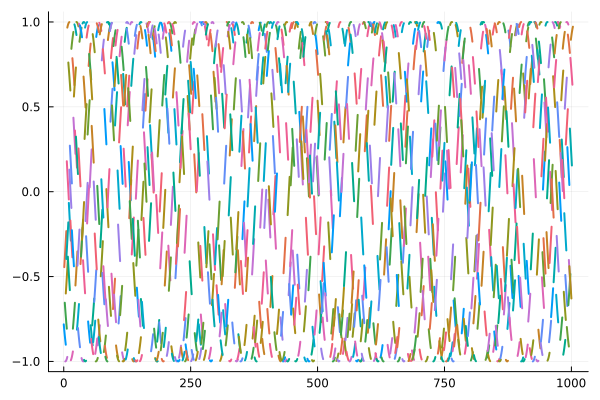

In [14]:
X, _ = trendy_sine(ntimepoints, ntrain_instances; sigma = sigma, slope = 0, rng = rng, period = period)
Y, _ = trendy_sine(ntimepoints, ntest_instances; sigma = sigma, slope = 0, rng = rng, period = period)
println(typeof(X), " ", size(X))
println(X)
p = plot(legend = false)
offset = 0 
for i in 1:ntrain_instances
    plot!(offset:(offset + ntimepoints - 1), X[i, :], label="", lw=2)
    offset += 1
end
display(p)

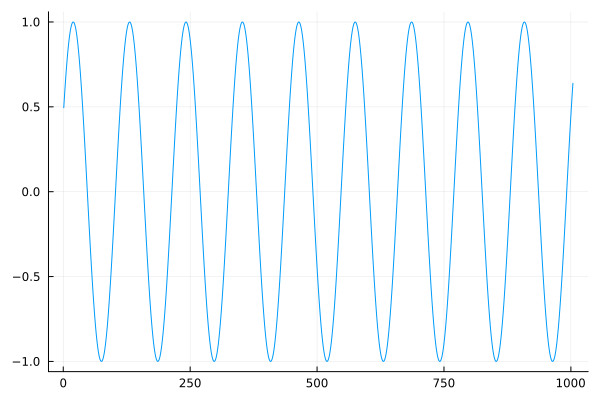

In [15]:
plot(X_train[:], legend = false)

In [16]:
function create_overlapping_windows(X_train, ntimepoints)
    n_samples = length(X_train) - ntimepoints + 1
    X_train_windows = Matrix{Float64}(undef, n_samples, ntimepoints)
    for i in 1:n_samples
        X_train_windows[i, :] = X_train[i:i+ntimepoints-1]
    end
    return X_train_windows
end;

Matrix{Float64} (1000, 5)
[0.49473400172882886 0.5430650621261482 0.5896596507602767 0.6343687796127919 0.6770494894966208; 0.5430650621261482 0.5896596507602767 0.6343687796127919 0.6770494894966208 0.7175653071736287; 0.5896596507602767 0.6343687796127919 0.6770494894966208 0.7175653071736287 0.7557866817331323; 0.6343687796127919 0.6770494894966208 0.7175653071736287 0.7557866817331323 0.7915913988360005; 0.6770494894966208 0.7175653071736287 0.7557866817331323 0.7915913988360005 0.8248649714997811; 0.7175653071736287 0.7557866817331323 0.7915913988360005 0.8248649714997811 0.8555010061753012; 0.7557866817331323 0.7915913988360005 0.8248649714997811 0.8555010061753012 0.8834015429442011; 0.7915913988360005 0.8248649714997811 0.8555010061753012 0.8834015429442011 0.9084773687496004; 0.8248649714997811 0.8555010061753012 0.8834015429442011 0.9084773687496004 0.9306483026583355; 0.8555010061753012 0.8834015429442011 0.9084773687496004 0.9306483026583355 0.9498434522426278; 0.8834015429

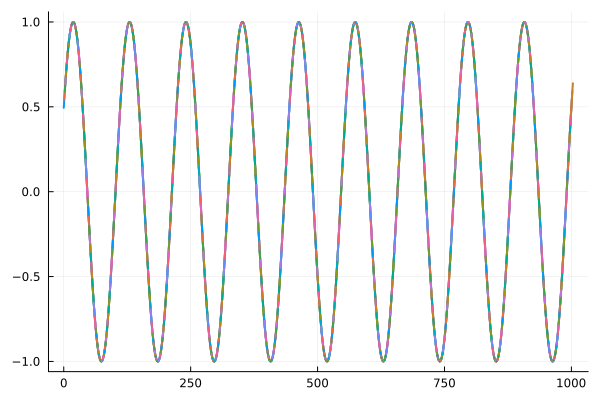

In [17]:
X_train_windows = create_overlapping_windows(X_train, ntimepoints);
X_test_windows = create_overlapping_windows(X_test, ntimepoints);
println(typeof(X_train_windows), " ", size(X_train_windows))
println(X_train_windows)
p = plot(legend = false)
offset = 0 
for i in 1:ntrain_instances
    plot!(offset:(offset + ntimepoints - 1), X_train_windows[i, :], label="", lw=2)
    offset += 1
end
display(p)

In [18]:
opts = MPSOptions(d = d, chi_max = chi_max, sigmoid_transform = false, nsweeps = sweeps);

In [19]:
println("Timing first set of operations:")
@time begin
    mps, info, test_states = @noprint fitMPS(X_train_windows, opts);
    imp = @noprint init_imputation_problem(mps, X_test_windows);
    _, _, _, stats, _ = @noprint MPS_impute(imp, class, instance_idx, impute_sites, method);
end

println("Timing second set of operations:")
@time begin
    mps1, info1, test_states1 = @noprint fitMPS(X, opts);
    imp1 = @noprint init_imputation_problem(mps1, Y);
    _, _, _, stats1, _ = @noprint MPS_impute(imp1, class, instance_idx, impute_sites, method);
end

Timing first set of operations:
  8.722624 seconds (51.97 M allocations: 10.794 GiB, 22.21% gc time)
Timing second set of operations:
  9.570156 seconds (51.97 M allocations: 10.726 GiB, 22.00% gc time)


([[-0.9770494434617228, -0.9634470015463877, -0.9467639001848965, -0.9270534842459535, -0.5792999954371741]], [[0.0, 0.0, 0.0, 0.0, 0.1948999808797407]], [-0.9770494434617228, -0.9634470015463877, -0.9467639001848965, -0.9270534842459535, -0.904378778554953], Any[Dict(:MAE => 0.3250787831177788, :MAPE => 0.35944981331516945, :NN_MAE => 0.0003492088631685819, :NN_MAPE => 0.0003861312001665493)], Plots.Plot{Plots.GRBackend}[Plot{Plots.GRBackend() n=3}])

In [20]:
println("From 1: ", stats)
println("From rng: ", stats1)

From 1: Any[Dict(:MAE => 0.08056783996332711, :MAPE => 1.571509933546961, :NN_MAE => 0.0003342798024798671, :NN_MAPE => 0.006520269507291548)]
From rng: Any[Dict(:MAE => 0.3250787831177788, :MAPE => 0.35944981331516945, :NN_MAE => 0.0003492088631685819, :NN_MAPE => 0.0003861312001665493)]


able to set each variable as a vector as to determine the relationships better and also have a single function perform the multistep forecasting

In [42]:
function params(d::Union{Int, Vector},
    chi_max::Union{Int, Vector},
    ntimepoints::Union{Int, Vector},
    ntrain_instances::Union{Int, Vector},
    ntest_instances::Union{Int, Vector},
    sigma::Union{Number, Vector};
    period::Union{Number, Vector}=nothing,
    final_multiplier::Union{Number, Vector}=20,
    sweeps::Union{Int, Vector}=20,
    )

    rng = Xoshiro(1)

    params = Dict(
    :d => d,
    :chi_max => chi_max,
    :ntimepoints => ntimepoints,
    :ntrain_instances => ntrain_instances,
    :ntest_instances => ntest_instances,
    :sigma => sigma,
    :period => period,
    :final_multiplier => final_multiplier,
    :rng => rng,
    :sweeps => sweeps
    )

    return params
end;


In [43]:
function create_overlapping_windows(X_train, ntimepoints)
    n_samples = length(X_train) - ntimepoints + 1
    X_train_windows = Matrix{Float64}(undef, n_samples, ntimepoints)
    for i in 1:n_samples
        X_train_windows[i, :] = X_train[i:i+ntimepoints-1]
    end
    return X_train_windows
end;

In [44]:
function get_test_losses_singleseries(params::Dict)
    d = params[:d]
    chi_max = params[:chi_max]
    ntimepoints = params[:ntimepoints]
    ntrain_instances = params[:ntrain_instances]
    ntest_instances = params[:ntest_instances]
    sigma = params[:sigma]
    period = params[:period]
    class = 0
    instance_idx = 1
    impute_sites = [ntimepoints]
    method = :median
    rng = params[:rng]
    sweeps = params[:sweeps]

    X_train, info_train = trendy_sine(ntimepoints*ntrain_instances, 1; sigma = sigma,slope = 0, rng = rng,period = period);
    X_test, info_test = trendy_sine(ntimepoints*ntest_instances, 1; sigma = sigma,slope = 0, rng = rng, period = period);

    X_train_windows = create_overlapping_windows(X_train, ntimepoints)
    X_test_windows = create_overlapping_windows(X_test, ntimepoints)

    # println(typeof(X_train), " ", size(X_train))
    # println(typeof(X_train_windows), " ", size(X_train_windows))

    opts = MPSOptions(d = d, chi_max = chi_max, sigmoid_transform = false, nsweeps = sweeps)

    mps, info, test_states = fitMPS(X_train_windows, opts);

    imp = init_imputation_problem(mps,X_test_windows);

    _, _, _, stats, _ = MPS_impute(imp, class, instance_idx, impute_sites, method);

    return stats[1], info_train, info_test
end;


In [49]:

function grid_search(params::Dict)
    
    param_name, param_values = "", []

    for (key, value) in params
        if isa(value, Vector)
            param_name, param_values = key, value
            println(param_name, " ", param_values)
            break
        end
    end

    if param_name == ""
        error("No vector parameter found for grid search.")
    end

    results = Array{Number, 2}(undef, length(param_values), 5)
    results[:,:] .= 0.0
    train_phases = Array{Vector{Float64}, 1}(undef, length(param_values))
    test_phases = Array{Vector{Float64}, 1}(undef, length(param_values))
    println("Begun Looping")
    for (i,value) in enumerate(param_values)
        
        updated_params = deepcopy(params)
        updated_params[param_name] = value

        rng = Xoshiro(Int64(round(value*100000)) + n)

        updated_params[:rng] = rng

        loss, info_train, info_test = get_test_losses_singleseries(updated_params)

        train_phases[i] = info_train[:phase]
        test_phases[i] = info_test[:phase]

        results[i,:] .= [value, loss[:MAE], loss[:MAPE],loss[:NN_MAE], loss[:NN_MAPE]]
        println("Completed Parameters: ", i, " of ", length(param_values))
    end;

    return results, train_phases, test_phases
end;

In [46]:
# function grid_search_N(params::Dict, num_searches::Int)
    
#     param_name, param_values = "", []

#     for (key, value) in params
#         if isa(value, Vector)
#             param_name, param_values = key, value
#             println(param_name, " ", param_values)
#             break
#         end
#     end
#     return param_name, param_values, mean_results, std_results, train_phases, test_phases, all_results

#     if param_name == ""
#         error("No vector parameter found for grid search.")
#     end

#     # Initialize arrays to store results for averaging and error calculations
#     all_results = Array{Number, 3}(undef, length(param_values), 5, num_searches)
#     all_results[:,:,:] .= 0.0
#     train_phases = Array{Vector{Float64}, 2}(undef, length(param_values), num_searches)
#     test_phases = Array{Vector{Float64}, 2}(undef, length(param_values), num_searches)

#     println("Begun Grid Search Looping")

#     for n in 1:num_searches
#         println("Grid Search Iteration: ", n, " of ", num_searches)
#         for (i, value) in enumerate(param_values)
            
#             updated_params = deepcopy(params)
#             updated_params[param_name] = value

#             rng = Xoshiro(Int64(round(value*100000)) + n)  # Change seed per iteration
#             updated_params[:rng] = rng

#             loss, info_train, info_test = get_test_losses(updated_params)

#             train_phases[i, n] = info_train[:phase]
#             test_phases[i, n] = info_test[:phase]

#             all_results[i,:,n] .= [value, loss[:MAE], loss[:MAPE], loss[:NN_MAE], loss[:NN_MAPE]]
#             println("Completed Parameters: ", i, " of ", length(param_values))
#         end
#     end

#     # Calculate mean and standard deviation across grid searches
#     mean_results = mean(all_results, dims=3)
#     std_results = std(all_results, dims=3)

#     # Squeeze the singleton dimension
#     mean_results = dropdims(mean_results, dims=3)
#     std_results = dropdims(std_results, dims=3)

#     return mean_results, std_results, train_phases, test_phases
# end;

In [47]:
function grid_search_N(params::Dict, num_searches::Int)
    
    param_name, param_values = "", []
    println(typeof(params[:rng]))
    for (key, value) in params
        if isa(value, Vector)
            param_name, param_values = key, value
            println(param_name, " ", param_values)
            break
        end
    end

    if param_name == ""
        error("No vector parameter found for grid search.")
    end

    # Initialize arrays to store results for averaging and error calculations
    all_results = Array{Number, 3}(undef, length(param_values), 5, num_searches)
    all_results[:,:,:] .= 0.0
    train_phases = Array{Vector{Float64}, 2}(undef, length(param_values), num_searches)
    test_phases = Array{Vector{Float64}, 2}(undef, length(param_values), num_searches)

    println("Begun Grid Search Looping")

    for n in 1:num_searches
        println("Grid Search Iteration: ", n, " of ", num_searches)
        for (i, value) in enumerate(param_values)
            
            updated_params = deepcopy(params)
            updated_params[param_name] = value

            rng = Xoshiro(Int64(round(value*100000)) + n)
            updated_params[:rng] = rng


            loss, info_train, info_test = get_test_losses_singleseries(updated_params)

            train_phases[i, n] = info_train[:phase]
            test_phases[i, n] = info_test[:phase]

            all_results[i,:,n] .= [value, loss[:MAE], loss[:MAPE], loss[:NN_MAE], loss[:NN_MAPE]]
            println("Completed Parameters: ", i, " of ", length(param_values))
        end
    end

    # Calculate mean and standard deviation across grid searches
    mean_results = mean(all_results, dims=3)
    std_results = std(all_results, dims=3)

    # Squeeze the singleton dimension
    mean_results = dropdims(mean_results, dims=3)
    std_results = dropdims(std_results, dims=3)

    # Save raw results
    @info "Saving raw results..."
    raw_results_file = "$(param_name)_$(param_values)_sigma=$(params[:sigma])_chi_max=$(params[:chi_max])_d=$(params[:d])_period=$(params[:period]).jls"
    serialize(raw_results_file, (all_results, train_phases, test_phases))
    @info "Raw results saved to $raw_results_file"

    # Return raw results along with mean and std
    return param_name, param_values, mean_results, std_results, train_phases, test_phases, all_results
end;

In [ ]:
d = 5
chi_max = 40
ntimepoints = convert.(Int,vcat(range(10,11,2)))
ntrain_length = 1000
ntest_length = 500
period = 100
sigma = 0.1
sweeps = 20
final_multiplier = 1
num_searches = 10

println(typeof(ntimepoints), ntimepoints)

test_params = params(d, chi_max, ntimepoints, ntrain_instances, ntest_instances, sigma; period = period, final_multiplier = final_multiplier, sweeps = sweeps)

param_name, param_values, mean_results, std_results, train_phases, test_phases, all_results = grid_search_N(test_params, num_searches)

Vector{Int64}[10, 11]
Xoshiro
ntimepoints [10, 11]
Begun Grid Search Looping
Grid Search Iteration: 1 of 10
Generating initial weight MPS with bond dimension χ_init = 4
        using random state 1234.
Initialising train states.
Using 1 iterations per update.
Training KL Div. 12.176480022267032 | Training acc. 1.0.
Using optimiser CustomGD with the "TSGO" algorithm
Starting backward sweeep: [1/20]
Backward sweep finished.
Starting forward sweep: [1/20]
Finished sweep 1. Time for sweep: 38.48s
Training KL Div. 3.2210451120818555 | Training acc. 1.0.
Using optimiser CustomGD with the "TSGO" algorithm
Starting backward sweeep: [2/20]
Backward sweep finished.
Starting forward sweep: [2/20]
Finished sweep 2. Time for sweep: 26.79s
Training KL Div. 1.3860242996727545 | Training acc. 1.0.
Using optimiser CustomGD with the "TSGO" algorithm
Starting backward sweeep: [3/20]
Backward sweep finished.
Starting forward sweep: [3/20]
Finished sweep 3. Time for sweep: 24.2s
Training KL Div. 0.33771298

┌ Info: Saving raw results...
└ @ Main c:\Users\Lukas Robinson\Documents\GitHub\Stationary-MPS-Honours\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X12sZmlsZQ==.jl:55
┌ Info: Raw results saved to ntimepoints_[10, 11]_sigma=0.1_chi_max=40_d=5_period=100.jls
└ @ Main c:\Users\Lukas Robinson\Documents\GitHub\Stationary-MPS-Honours\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X12sZmlsZQ==.jl:58


(:ntimepoints, [10, 11], Number[10.0 0.17191680361000686 … 0.09152130831524237 0.18076525662698115; 11.0 0.11283743960688115 … 0.12239471639849189 0.25334101467404185], [0.0 0.1131207975057521 … 0.08028223913849333 0.20592711371056938; 0.0 0.08376237858490386 … 0.10597531564678 0.24947799031280268], [[0.3287954291665264] [1.354922790684823] … [1.7672732908268083] [5.6201629908810915]; [6.27430745531376] [1.8670038196832193] … [0.8316593425508337] [1.1951672955650592]], [[4.116234558791391] [2.7677604882501377] … [5.553718013826534] [5.020901548382623]; [5.884790425953633] [5.9596860136545216] … [5.42922186429429] [4.55556096517376]], Number[10.0 0.203610173011336 … 0.06327776872709312 0.05568826947574701; 11.0 0.3235255985839155 … 0.1060220785862824 0.30181031410854664;;; 10.0 0.18245286453912513 … 0.06749583681888041 0.21932144151573488; 11.0 0.06430911590647698 … 0.3029157075395284 0.8038442434856862;;; 10.0 0.035190972971258505 … 0.15032280951235877 0.21771092915152906; 11.0 0.10670

Note if the seed is the same then there are overlaps


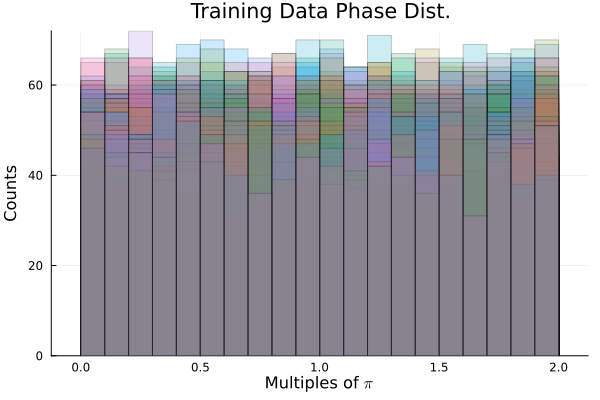

In [9]:
b_range = range(0, 2, length=21)
hist = histogram(train_phases[:]./pi, bins = b_range, alpha = 0.2, legend = false)
xlabel!("Multiples of \$\\pi\$")
ylabel!("Counts")
title!("Training Data Phase Dist.")
println("Note if the seed is the same then there are overlaps")
display(hist)
# histogram(x, label="Experimental", bins=b_range)

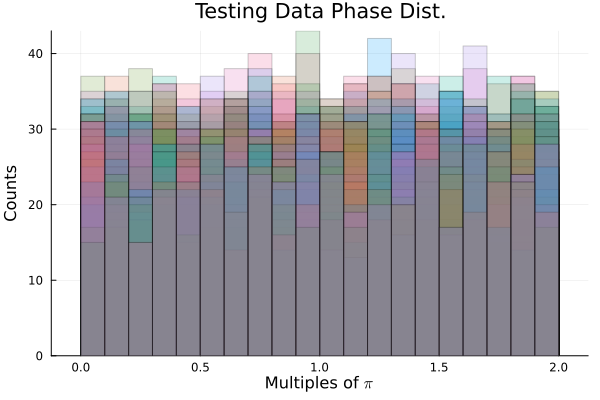

Note if the seed is the same then there are overlaps


In [10]:
b_range = range(0, 2, length=21)
hist = histogram(test_phases[:]./pi, bins = b_range, alpha = 0.2, legend = false)
xlabel!("Multiples of \$\\pi\$")
ylabel!("Counts")
title!("Testing Data Phase Dist.")
println("Note if the seed is the same then there are overlaps")
display(hist)
# histogram(x, label="Experimental", bins=b_range)

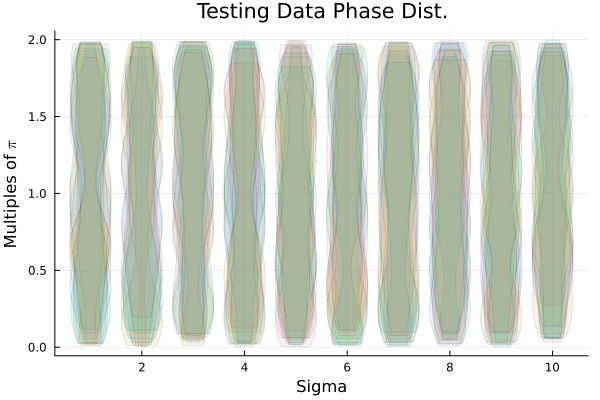

Note if the seed is the same then there are overlaps


In [11]:
b_range = range(0, 2, length=11)
data = test_phases[1,:]./pi  # Normalize by π

# data = vcat([test_phases[i, :]./pi for i in 1:size(test_phases)[2]]...)current_vals[:]

group = repeat(collect(1:size(test_phases)[1]), inner=size(test_phases, 2))

# Create the violin plot
v = violin(group, data,
    bins=b_range, 
    alpha=0.1, 
    legend=false, 
    xlabel="Sigma", 
    ylabel="Multiples of \$\\pi\$", 
    title="Testing Data Phase Dist." #, xlims = [0,10]
)

# v = violin(data, bins=b_range, 
#     alpha=0.5, 
#     legend=false, 
#     xlabel="Sigma", 
#     ylabel="Multiples of \$\\pi\$", 
#     title="Testing Data Phase Dist." #, xlims = [0,10]
# )

display(v)
println("Note if the seed is the same then there are overlaps")

In [12]:
println(size(all_results))
println(size(std_results))
println(size(std_results[1]))

(10, 5, 10)
(10, 5)
()


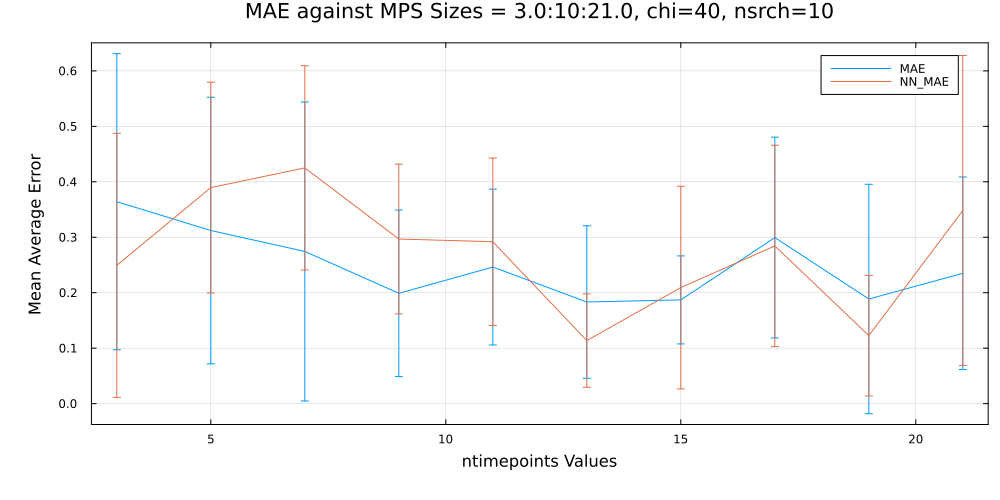

(10, 4)


In [14]:
using Plots.PlotMeasures

values = mean_results[:, 1]
losses = mean_results[:, 2:end]
errors = std_results[:, 2:end]

width = 1000
height = 500

println(size(errors))

gr(display_type=:inline)

p = plot(size = (width, height), framestyle=:box, bottom_margin = 10mm, left_margin = 10mm, top_margin = 5mm)
plot!(values[:], losses[:, 1], yerror=errors[:, 1], markerstrokecolor = :auto, label="MAE", 
    title="MAE against MPS Sizes = $(minimum(values)):$(length(values)):$(maximum(values)), chi=$(test_params[:chi_max]), nsrch=$num_searches", xlabel="$(param_name) Values", ylabel="Mean Average Error", legend=:topright)
plot!(values[:], losses[:, 3], yerror=errors[:, 3], markerstrokecolor = :auto, label="NN_MAE")

display(p)

In [1]:
savefig(p, "LossesVSWindow_Size_chi=$(chi_max)_Nsearches=$(num_searches)_Sigma=$(sigma)_ntimepoints=$(minimum(ntimepoints)):$(maximum(ntimepoints))_period=$(period).png")

UndefVarError: UndefVarError: `savefig` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

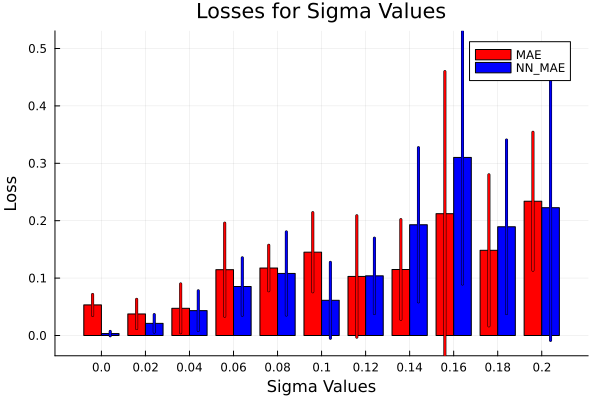

In [ ]:
bar_width = 0.4

x = collect(1:length(values))

x_shift1 = x .- bar_width/2
x_shift2 = x .+ bar_width/2

grouped_losses = [losses[:, 1] losses[:, 3]]
grouped_errors = [errors[:, 1] errors[:, 3]]
labels = ["MAE", "NN_MAE"]

p = plot()

# Plot the bars first
bar!(x_shift1, grouped_losses[:, 1], bar_width=bar_width, label="MAE", color=:red)
bar!(x_shift2, grouped_losses[:, 2], bar_width=bar_width, label="NN_MAE", color=:blue)

# Add outlined error bars for MAE
for i in 1:length(x_shift1)
    # Outline
    plot!([x_shift1[i], x_shift1[i]], 
          [grouped_losses[i, 1] - grouped_errors[i, 1], grouped_losses[i, 1] + grouped_errors[i, 1]], 
          linecolor=:black, linewidth=3, legend=false, labels = false)
    # Colored error bar
    plot!([x_shift1[i], x_shift1[i]], 
          [grouped_losses[i, 1] - grouped_errors[i, 1], grouped_losses[i, 1] + grouped_errors[i, 1]], 
          linecolor=:red, linewidth=2, legend=false, labels = false)
end

# Add outlined error bars for NN_MAE
for i in 1:length(x_shift2)
    # Outline
    plot!([x_shift2[i], x_shift2[i]], 
          [grouped_losses[i, 2] - grouped_errors[i, 2], grouped_losses[i, 2] + grouped_errors[i, 2]], 
          linecolor=:black, linewidth=3, legend=false, labels = false)
    # Colored error bar
    plot!([x_shift2[i], x_shift2[i]], 
          [grouped_losses[i, 2] - grouped_errors[i, 2], grouped_losses[i, 2] + grouped_errors[i, 2]], 
          linecolor=:blue, linewidth=2, legend=false, labels = false)
end

# Add labels and title
plot!(title="Losses for Sigma Values", xlabel="Sigma Values", 
    xticks=(x, values), ylabel="Loss", legend=:topright)

display(p)
